In [20]:
#import needed libraries
import numpy as np
import time
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.efficientnet import Conv2dNormActivation
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [21]:
dataset = torch.load('preprocessed_dataset.pt')

In [22]:
# Extract string labels
string_labels = [label for _, label in dataset]

# Encode
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(string_labels)

# Stack tensors and create TensorDataset
images = torch.stack([img for img, _ in dataset])
labels = torch.tensor(encoded_labels, dtype=torch.long)
tensor_dataset = TensorDataset(images, labels)

In [23]:
train_size = int(0.7 * len(tensor_dataset))
val_size = int(0.15 * len(tensor_dataset))
test_size = len(tensor_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(tensor_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print(f"train set has {train_size} samples")
print(f"validation set has {val_size} samples")
print(f"test set has {test_size} samples")

train set has 130528 samples
validation set has 27970 samples
test set has 27972 samples


In [24]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

# Modify first conv layer to accept 1-channel input (grayscale)
model.features[0][0] = Conv2dNormActivation(
    in_channels=1,
    out_channels=32,
    kernel_size=3,
    stride=2,
    padding=1,
    norm_layer=nn.BatchNorm2d,
    activation_layer=nn.SiLU,
)

# Replace the final fully connected layer for 136 classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 136)

In [25]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

device

device(type='cuda')

In [27]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [28]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []


def train():
    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_fn(output, y)
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_loss += batch_loss.item() * x.size(0)  # sum weighted by batch size
        pred = output.argmax(dim=1)
        total_correct += pred.eq(y).sum().item()
        total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f'Train - Loss: {avg_loss:.4f} Accuracy: {accuracy:.4f} \n')

def valid():
    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            batch_loss = loss_fn(output, y)

            total_loss += batch_loss.item() * x.size(0)
            pred = output.argmax(dim=1)
            total_correct += pred.eq(y).sum().item()
            total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    valid_losses.append(avg_loss)
    valid_accuracies.append(accuracy)
    print(f'Valid - Loss: {avg_loss:.4f} Accuracy: {accuracy:.4f}\n')

In [29]:
epochs = 20

for epoch in range(1, epochs+1):
    start_time=time.time()
    print(f"Epoch nb {epoch} Starting...")
    train()
    valid()
    end_time=time.time()
    print(f"epoch duration is {end_time-start_time:.2f}s")
    if epoch % 5==0:
        torch.save({
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'valid_losses': valid_losses,
        'valid_accuracies': valid_accuracies
    }, f'model_checkpoint_{epoch}.pth')

print(f"training complete!")


Epoch nb 1 Starting...
Train - Loss: 1.6344 Accuracy: 0.7489 

Valid - Loss: 1.2429 Accuracy: 0.8558

epoch duration is 68.66s
Epoch nb 2 Starting...
Train - Loss: 1.2537 Accuracy: 0.8571 

Valid - Loss: 1.2038 Accuracy: 0.8692

epoch duration is 68.74s
Epoch nb 3 Starting...
Train - Loss: 1.2121 Accuracy: 0.8687 

Valid - Loss: 1.1870 Accuracy: 0.8794

epoch duration is 68.64s
Epoch nb 4 Starting...
Train - Loss: 1.1837 Accuracy: 0.8777 

Valid - Loss: 1.1503 Accuracy: 0.8839

epoch duration is 69.74s
Epoch nb 5 Starting...
Train - Loss: 1.1582 Accuracy: 0.8859 

Valid - Loss: 1.1355 Accuracy: 0.8904

epoch duration is 70.80s
Epoch nb 6 Starting...
Train - Loss: 1.1436 Accuracy: 0.8906 

Valid - Loss: 1.1417 Accuracy: 0.8912

epoch duration is 68.80s
Epoch nb 7 Starting...
Train - Loss: 1.1284 Accuracy: 0.8950 

Valid - Loss: 1.1053 Accuracy: 0.9003

epoch duration is 68.82s
Epoch nb 8 Starting...
Train - Loss: 1.1179 Accuracy: 0.8986 

Valid - Loss: 1.0975 Accuracy: 0.9009

epoch dur

In [30]:
def test():
    total_loss = 0
    total_correct = 0
    total_samples = 0

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            preds = output.argmax(dim=1)

            batch_loss = loss_fn(output, y)
            total_loss += batch_loss.item() * x.size(0)
            total_correct += preds.eq(y).sum().item()
            total_samples += x.size(0)
            
            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f'Test - Loss: {avg_loss:.4f} Accuracy: {accuracy:.4f}\n')
    return y_true, y_pred

y_true, y_pred = test()

Test - Loss: 1.0545 Accuracy: 0.9170



In [31]:
labels = list(range(len(label_encoder.classes_)))
target_names = label_encoder.inverse_transform(labels)

print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

                     precision    recall  f1-score   support

                  +       0.95      1.00      0.97       131
                  -       0.98      0.99      0.99       168
                  /       0.99      0.96      0.97       300
                  0       0.61      0.91      0.73       183
                  1       0.96      0.87      0.91       173
                  2       0.96      1.00      0.98       212
                  3       1.00      0.99      0.99       197
                  4       0.96      1.00      0.98       102
                  5       0.91      1.00      0.95       116
                  6       0.97      0.94      0.96       140
                  7       0.98      1.00      0.99        98
                  8       0.99      0.98      0.99       194
                  9       0.70      0.99      0.82       142
                  <       0.96      1.00      0.98       172
                  >       0.97      1.00      0.99       138
                  A    

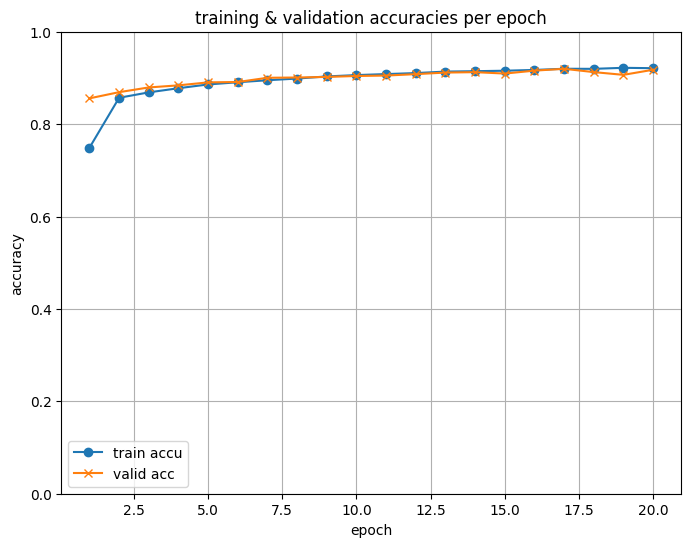

In [32]:
x=range(1, len(train_accuracies) + 1)
plt.figure(figsize=(8, 6))
train_line, = plt.plot(x, train_accuracies, marker='o', label='train accu')
valid_line, = plt.plot(x, valid_accuracies, marker='x', label='valid acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.title('training & validation accuracies per epoch')
plt.ylim(0, 1)
plt.legend(handles=[train_line, valid_line])
plt.show()

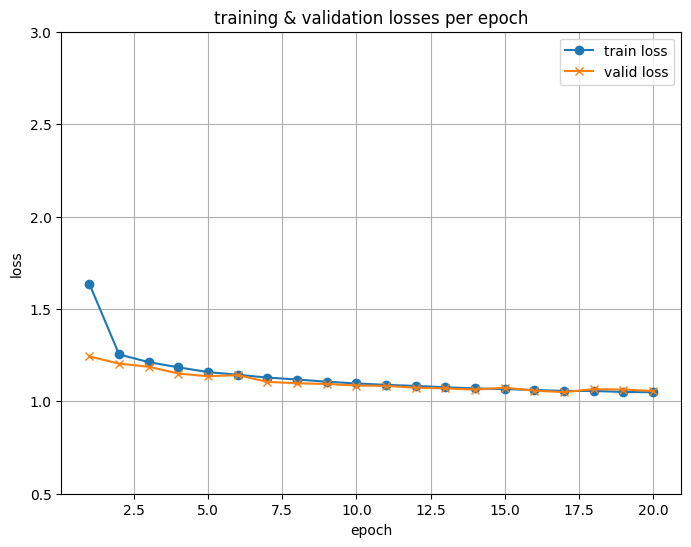

In [33]:
plt.figure(figsize=(8, 6))
train_line, = plt.plot(x, train_losses, marker='o', label='train loss')
valid_line, = plt.plot(x, valid_losses, marker='x', label='valid loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.title('training & validation losses per epoch')
plt.ylim(0.5, 3)
plt.legend(handles=[train_line, valid_line])
plt.show()